In [1]:
from benchmark.computational_time import chunk_size_influence
chunk_size_influence()

100%|██████████| 27/27 [00:06<00:00,  4.38it/s]



### Volume 100 ###
volume size: 100 | chunk size: (15, 15, 15) | ratio %: 15 | time: 16.17s
volume size: 200 | chunk size: (20, 20, 20) | ratio %: 20 | time: 7.51s
volume size: 300 | chunk size: (25, 25, 25) | ratio %: 25 | time: 5.05s


100%|██████████| 27/27 [00:40<00:00,  1.49s/it]



### Volume 200 ###
volume size: 100 | chunk size: (30, 30, 30) | ratio %: 15 | time: 25.60s
volume size: 200 | chunk size: (40, 40, 40) | ratio %: 20 | time: 17.00s
volume size: 300 | chunk size: (50, 50, 50) | ratio %: 25 | time: 17.92s


100%|██████████| 27/27 [02:19<00:00,  5.18s/it]



### Volume 300 ###
volume size: 100 | chunk size: (45, 45, 45) | ratio %: 15 | time: 65.08s
volume size: 200 | chunk size: (60, 60, 60) | ratio %: 20 | time: 54.90s
volume size: 300 | chunk size: (75, 75, 75) | ratio %: 25 | time: 54.26s


((135, 135, 135),
 [15, 20, 25, 30, 35, 40, 45],
 [65.08200573921204,
  54.89694595336914,
  54.26077651977539,
  92.01158547401428,
  64.75094270706177,
  94.90284705162048,
  140.83578395843506])

### Metadata

In [106]:
import tifffile as tiff
file = './data/raw/GT_A.tif'
image = tiff.imread(file)
print(image.shape, type(image))
with tiff.TiffFile(file) as tif:
    print(len(tif.pages))
    current_page = None
    for page in tif.pages:
        if current_page != page:
            print('\n====================')
            tags = page.tags
            for tag in tags.values():
                print(f'{tag.name} : {tag.value}')
            current_page = page

(3, 1448, 1320) <class 'numpy.ndarray'>
3

NewSubfileType : 0
ImageWidth : 1320
ImageLength : 1448
BitsPerSample : 8
PhotometricInterpretation : 1
ImageDescription : ImageJ=1.52a
images=3
slices=3
loop=false
StripOffsets : (177,)
SamplesPerPixel : 1
RowsPerStrip : 1448
StripByteCounts : (1911360,)

NewSubfileType : 0
ImageWidth : 1320
ImageLength : 1448
BitsPerSample : 8
PhotometricInterpretation : 1
ImageDescription : ImageJ=1.52a
images=3
slices=3
loop=false
StripOffsets : (1911537,)
SamplesPerPixel : 1
RowsPerStrip : 1448
StripByteCounts : (1911360,)

NewSubfileType : 0
ImageWidth : 1320
ImageLength : 1448
BitsPerSample : 8
PhotometricInterpretation : 1
ImageDescription : ImageJ=1.52a
images=3
slices=3
loop=false
StripOffsets : (3822897,)
SamplesPerPixel : 1
RowsPerStrip : 1448
StripByteCounts : (1911360,)


### Matrice affine

In [122]:
import nibabel as nib
import numpy as np

data = nib.load('./data/raw/appps1_cc.nii')
image = data.get_fdata().astype(np.float32)

print(image.shape, type(image))
print(data.affine)
print(data.header)

(544, 326, 500, 1) <class 'numpy.ndarray'>
[[  -1.     0.     0.   271.5]
 [   0.     1.     0.  -162.5]
 [   0.     0.     1.  -249.5]
 [   0.     0.     0.     1. ]]


Loading file ./data/processed/test_image ...
File ./data/processed/test_image loaded !


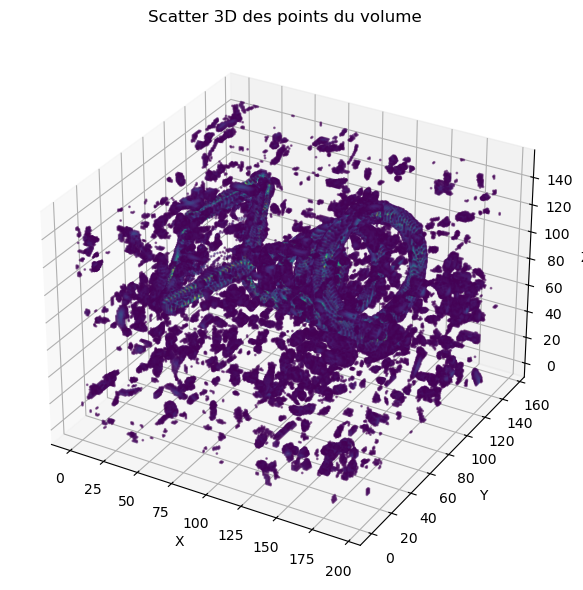

In [2]:
from utils.viewer import display_3d, scatter_volume
from utils.loader import load

image = load('./data/processed/test_image.nii')
scatter_volume(image, threshold=0.1)

Loading file ./data/test/test_image ...
File ./data/test/test_image loaded !
Loading file ./data/processed/test_image_gt ...
File ./data/processed/test_image_gt loaded !
Loading file ./data/processed/test_image ...
File ./data/processed/test_image loaded !


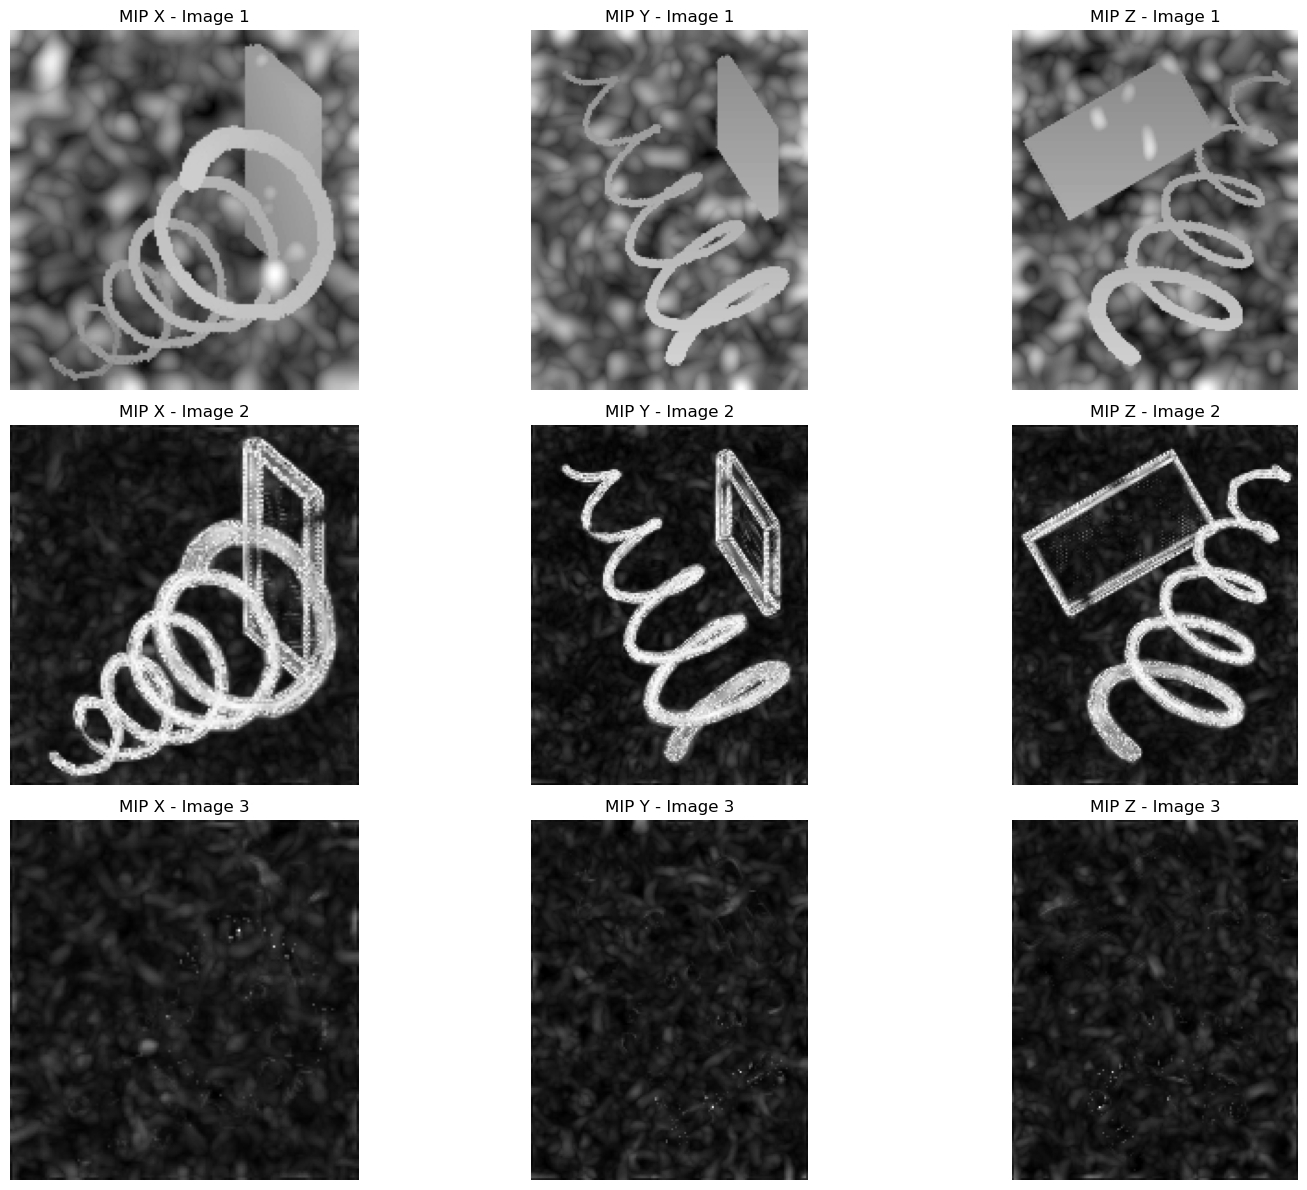

In [1]:
from utils.viewer import display_mip
from utils.loader import load
image1 = load('./data/test/test_image.nii')
image2 = load('./data/processed/test_image_gt.nii')
image3 = load('./data/processed/test_image.nii')

display_mip([image1, image3, image2])

In [ ]:
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
import numpy as np

def frangi_filter_old(
    image,
    sigmas=range(1, 10, 1),
    alpha=0.5,
    beta=0.5,
    gamma=None,
    black_ridges=True,
    mode='reflect',
    cval=0,
):
    
    image = image.astype(np.float32, copy=False)
    if not black_ridges:  # Normalize to black ridges.
        image = -image

    # Generate empty array for storing maximum value from different (sigma) scales
    filtered_image = np.zeros_like(image)
    for sigma in sigmas:  # Filter for all sigmas.
        eigvals = hessian_matrix_eigvals(
            hessian_matrix(
                image, sigma, mode=mode, cval=cval, use_gaussian_derivatives=True
            )
        )
        # Sort eigenvalues by magnitude.
        eigvals = np.sort(np.abs(eigvals), axis=0)
        
        if image.ndim == 2:
            lambda1, lambda2 = np.maximum(eigvals, 1e-10)
            r_a = np.inf  # implied by eq. (15).
            r_b = abs(lambda1) / lambda2  # eq. (15).
        else:  # ndim == 3
            # lambda2, lambda3 = np.maximum(eigvals[1:], 1e-10)
            lambda1, lambda2, lambda3 = np.maximum(eigvals, 1e-10)
            r_a = lambda2 / lambda3  # eq. (11).
            r_b = abs(lambda1) / np.sqrt(lambda2 * lambda3)  # eq. (10).
        s = np.sqrt((eigvals**2).sum(0))  # eq. (12).
        if gamma is None:
            gamma = s.max() / 2
            if gamma == 0:
                gamma = 1
        vesselness = 1.0 - np.exp(-(r_a**2) / (2 * alpha**2))  # plate sensitivity
        vesselness *= np.exp(-(r_b**2) / (2 * beta**2))  # blobness
        vesselness *= 1.0 - np.exp(-(s**2) / (2 * gamma**2))  # structuredness
        filtered_image = np.maximum(filtered_image, vesselness)
    return filtered_image  # Return pixel-wise max over all sigmas.


In [14]:
from src.frangi import frangi_filter
from utils.loader import load, save
from time import time
filename = './data/test/test_image.nii'
# filename = './data/raw/appps1_cc.nii'
image = load(filename)
t1 = time()
filtered_image = frangi_filter(image, scales=range(1, 10, 2), alpha=0.5, beta=0.5, gamma=5)
t2 = time()

Loading file ./data/test/test_image ...
File ./data/test/test_image loaded !


In [5]:
print(len(image)*len(range(1, 10, 2)))

975


Loading file ./data/test/test_image ...
File ./data/test/test_image loaded !


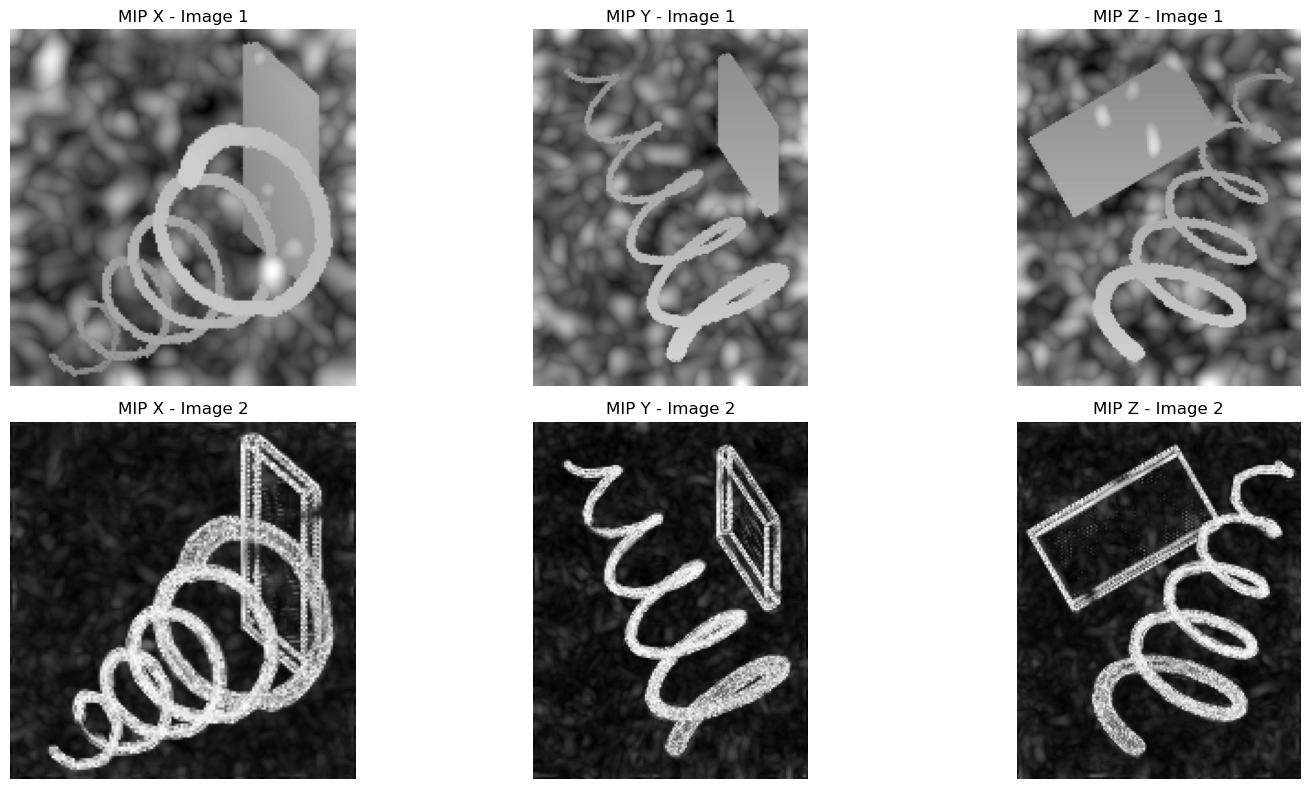

In [16]:
from utils.viewer import display_mip
from utils.loader import load
image1 = load('./data/test/test_image.nii')
image2 = filtered_image

display_mip([image1, image2])

Loading file ./data/raw/Data_B ...
File ./data/raw/Data_B loaded !


Loading file ./data/raw/Data_B ...
File ./data/raw/Data_B loaded !
Loading file ./data/raw/GT_B ...
File ./data/raw/GT_B loaded !


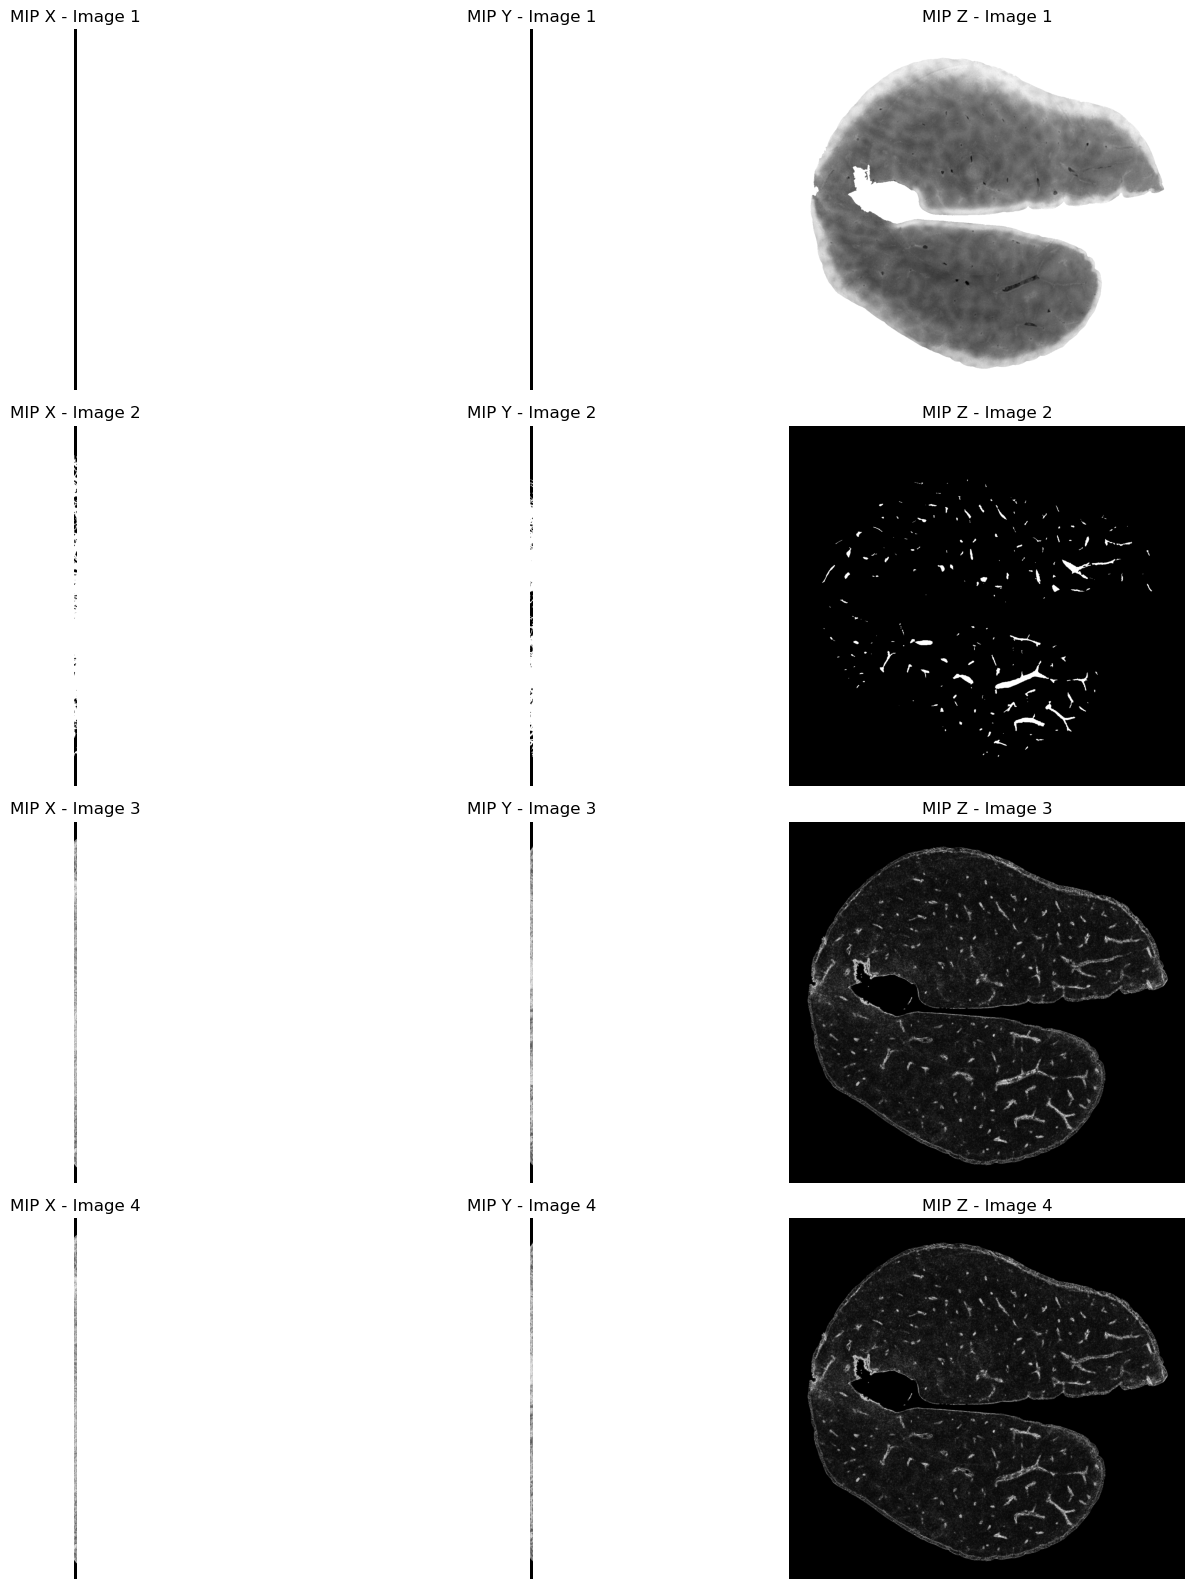

In [27]:
from utils.viewer import display_mip
from utils.loader import load
image1 = load('./data/raw/Data_B.tiff')
image2 = load('./data/raw/GT_B.tif')
image3 = filtered_image1
image4 = filtered_image2

display_mip([image1, image2, image3, image4])

In [28]:
from utils.loader import save 

save(filtered_image1, './data/test/filtered_image1.nii')
save(filtered_image2, './data/test/filtered_image2.nii')

Saving file ./data/test/filtered_image1 ...
File ./data/test/filtered_image1 saved !
Saving file ./data/test/filtered_image2 ...
File ./data/test/filtered_image2 saved !


In [33]:
from src.frangi import frangi_filter
from utils.loader import load, save


image = load('./data/raw/appps1_cc.nii')
filtered_image1 = frangi_filter(-image[:, :, :50], scales=range(1, 10, 2), alpha=0.5, beta=0.5, gamma=5)
filtered_image2 = frangi_filter(image[:, :, :50], scales=range(1, 10, 2), alpha=0.5, beta=0.5, gamma=5)

Loading file ./data/raw/appps1_cc ...
File ./data/raw/appps1_cc loaded !


Loading file ./data/raw/appps1_cc ...
File ./data/raw/appps1_cc loaded !


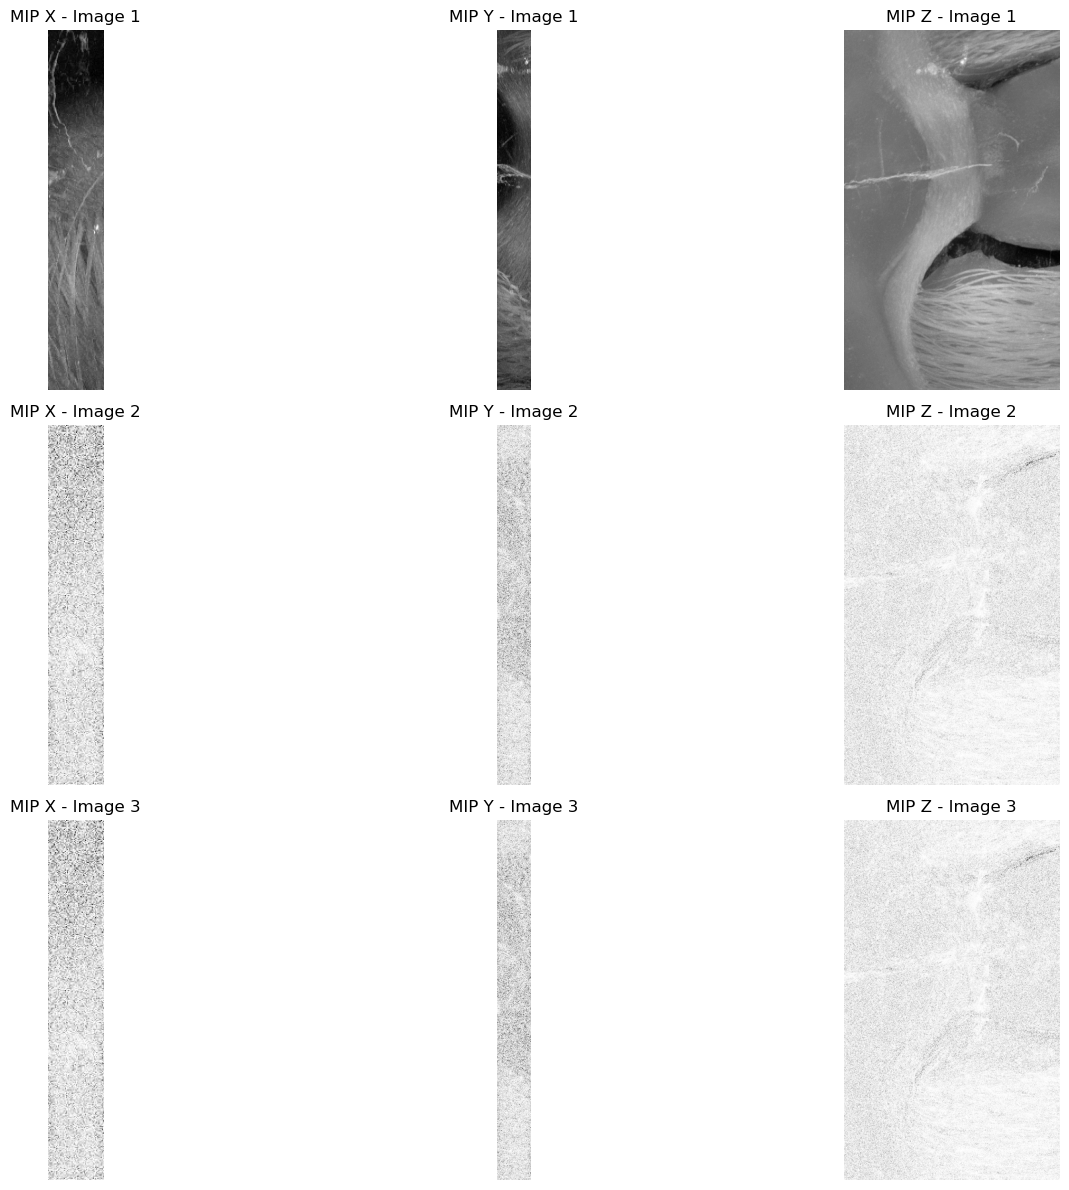

In [35]:
from utils.viewer import display_mip
from utils.loader import load
image1 = load('./data/raw/appps1_cc.nii')
image2 = filtered_image1
image3 = filtered_image2
# image2 = load('./data/processed/data_gt.nii')
# image3 = load('./data/processed/data.nii')

display_mip([image1[:, :, :50], image2, image3])

In [15]:
300*300*100/(100*100*100)*12/60

1.8

In [ ]:
from utils.loader import load
from src.frangi import frangi_filter
from skimage.filters import frangi

image = load('./data/la_001.nii.gz'(300, 300, 100))
filtered = frangi_filter(image, scales=range(1, 20, 4), alpha=0.5, beta=0.5, gamma=None)

<>:5: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
<>:5: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
C:\Users\noedo\AppData\Local\Temp\ipykernel_24704\931353849.py:5: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  image = load('./data/la_001.nii.gz'(300, 300, 100))


TypeError: 'str' object is not callable

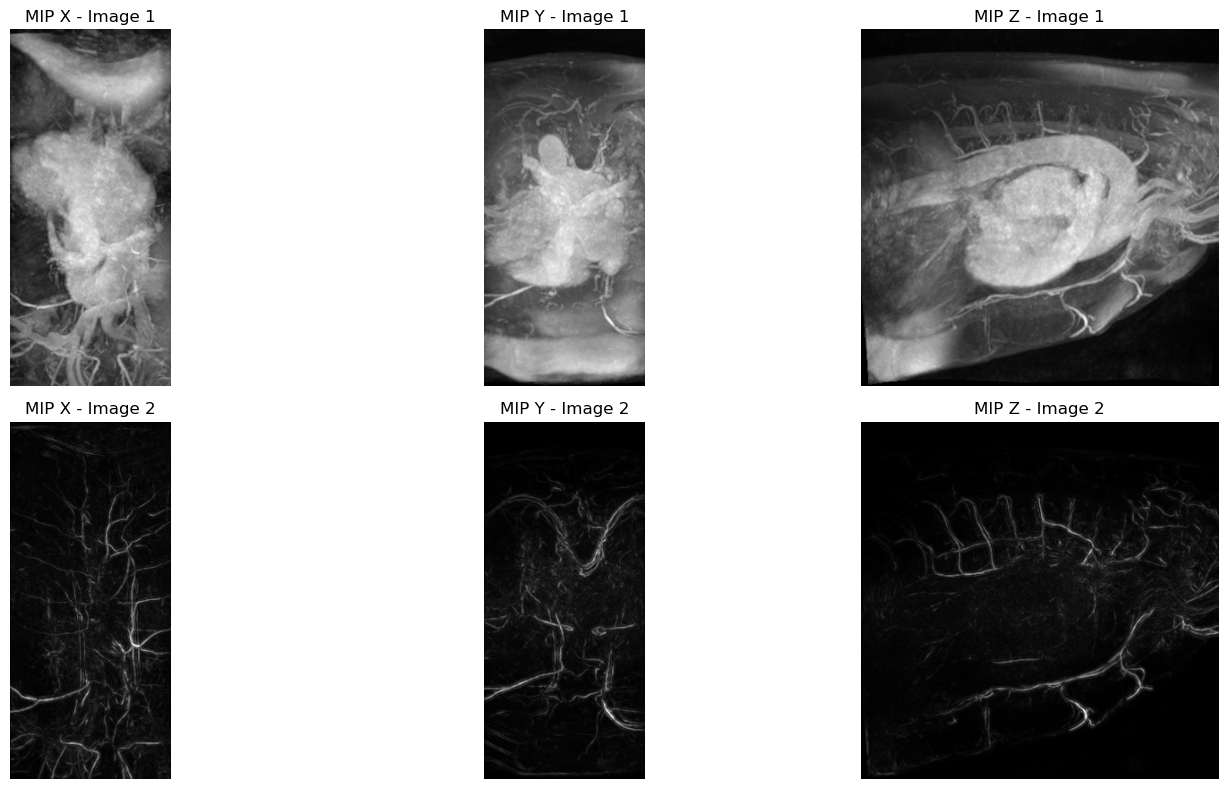

Saving file ./data/test/filtered ...
File ./data/test/filtered saved!


In [23]:
from utils.viewer import display_mip
from utils.loader import load, save

display_mip([image, filtered])
save(filtered, './data/test/filtered.nii')

Loading file VESSEL12_03 ...
Cropping to center with shape (150, 150, 150) ...
File VESSEL12_03 loaded with shape (150, 150, 150)!
gamma = 222.68145751953125


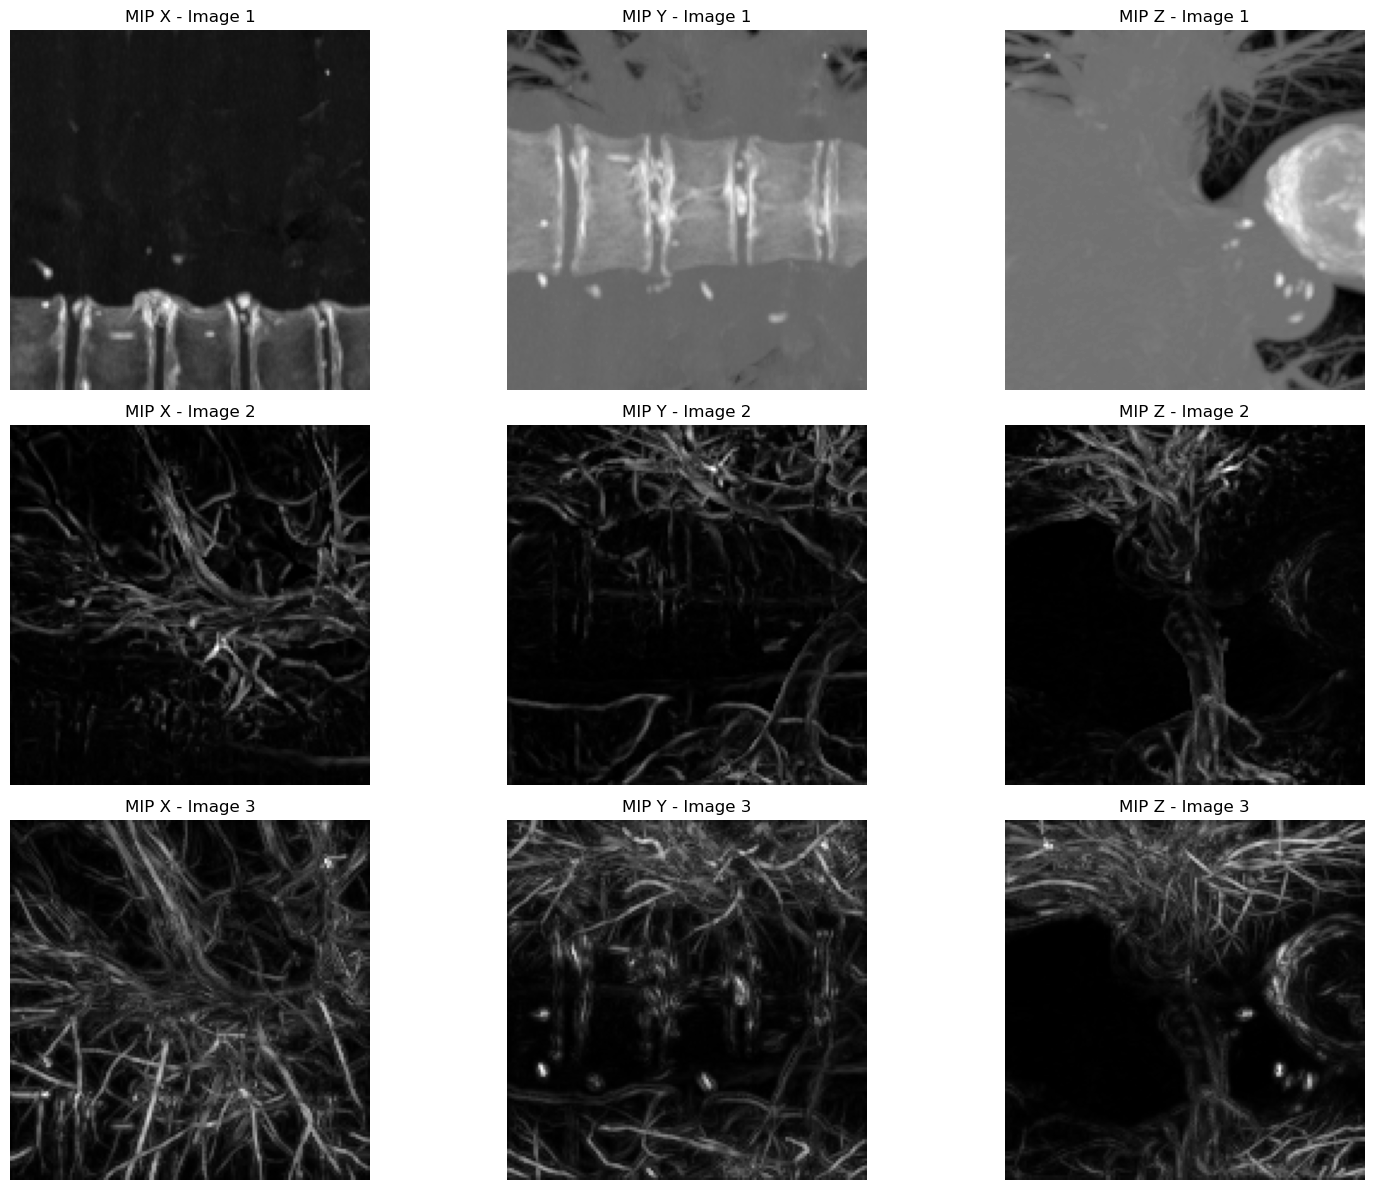

Saving file ./data/test/filtered ...
File ./data/test/filtered saved!


In [18]:
from utils.loader import load, save
from src.frangi import frangi_filter
from utils.viewer import display_mip
from skimage.filters import frangi

image = load('./data/test/vessels/VESSEL12_03.mhd', (150,150,150))

# filtered = frangi_filter(image, scales=range(1, 10, 2), alpha=0.5, beta=0.5, gamma=None)
filtered1 = frangi(image, sigmas=range(1, 10, 2), alpha=0.5, beta=0.5, gamma=None)
filtered2 = frangi_filter(image, scales=range(1, 10, 2), alpha=0.5, beta=0.5, gamma=None)

display_mip([image, filtered1, filtered2])
save(filtered, './data/test/filtered.nii')

pour le moment : On a un code qui permet d'attribuer par la méthode de frangi, une probabilité de vesselness aux différents voxels du volume. Pour pouvoir ensuite déterminer la précision de cette méthode, il me faut déterminer un seuil à sous lequel supprimer les voxels qui ne sont pas considérés comme des vaisseaux. Pour cela, je dois compter pour différent seuil, le nombre de voxels au dessus du seuil qui sont des vaisseau avec les labels et prendre le seuil qui maximise ceci. Je peut ensuite trouver l'accuracy. 

Schéma du pipeline :

- Chargement de l'image (prise en compte des différentes extensions possibles)
- Chunkage de l'image (pour accélérer le traitement, avec un overlap égale à la taille de l'échelle utilisée ?)
- Réhaussement par la méthode de frangi (incluera plus tard la méthode de calcul de la hessienne)
- Comparaison avec la vérité terrain
- Calcul de la précision

OBJECTIF : Comparaison des différentes implémentations de frangi pour avoir une base solide et stable pour la comparaison des méthodes de la hessienne. 

Ceci est une première approche pour mesurer l'efficacité de la méthode de frangi et ne tient pas compte des méthodes de segmentation.
Comparaison des différents hyperparamètres (alpha, beta, gamma, ... par grid search sur un sous-échantillon de l'image)

Visualiser les métadonnées